In [50]:
import os
import sys
import numpy as np
import numpy.typing as npt
from typing import List, Tuple
import matplotlib.pyplot as plt
import python_modules.Server as Server
from helpers.SDEModels import MeanRevertingSDE

In [51]:
currency = Server.GenericSecurities.GenericCurrency("CURRENCY")
stock = Server.GenericSecurities.GenericStock("STOCK", "CURRENCY")
simulation = Server.GenericSimulation({ "CURRENCY": currency, "STOCK": stock }, 1.0, 1000)
currency_id = simulation.get_security_id("CURRENCY")
stock_id = simulation.get_security_id("STOCK")
agent_id = simulation.add_user("AGENT")
anon_id = simulation.add_user("ANON")

In [52]:
rng = np.random.default_rng()
SDE = MeanRevertingSDE(rng)
REMOVAL_PERCENTAGE = 0.1
results = []
while True:
    current_step = simulation.get_tick()
    t = simulation.get_t()
    dt = simulation.get_dt()
    ORDER_COUNT = SDE.get_order_count(t, dt)
    ORDER_SIZE_MIN = 1
    ORDER_SIZE_MAX = 5
    
    if current_step == 0:
        price_distribution = rng.uniform(0.75, 1.0, size=ORDER_COUNT)
        volume_distribution = rng.integers(ORDER_SIZE_MIN, ORDER_SIZE_MAX, ORDER_COUNT)
        target = SDE.get_stock_price(t, dt)
        volatility = SDE.get_volatility(t, dt)
        SPREAD = SDE.get_spread(t, dt)
        HALF_SPREAD = SPREAD / 2

        bid_top_price = round(target - HALF_SPREAD, 2)
        bid_bottom_price = round(bid_top_price - 0.5 * volatility * bid_top_price, 2)
        bid_prices: List[float] = list(bid_top_price * price_distribution + bid_bottom_price * (1.0 - price_distribution))
        bids = [(Server.OrderSide.BID, price, volume_distribution[i]) for i, price in enumerate(bid_prices)]
        
        ask_bottom_price = round(target + HALF_SPREAD, 2)
        ask_top_price = round(ask_bottom_price + 0.5 * volatility * ask_bottom_price, 2)
        ask_prices: List[float] = list(ask_bottom_price * price_distribution + ask_top_price * (1.0 - price_distribution))
        asks = [(Server.OrderSide.ASK, price, volume_distribution[i]) for i, price in enumerate(ask_prices)]

        combined_orders: List[Tuple[Server.OrderSide, float, float]] = bids + asks
        rng.shuffle(combined_orders)

        for (side, price, volume) in combined_orders:
            simulation.submit_limit_order(anon_id, stock_id, side, round(price, 2), volume)
            pass
        pass
    else:
        orders_ANON = list(simulation.get_all_open_user_orders(anon_id, stock_id))
        
        # remove some percent of ANON orders
        if (k := int(len(orders_ANON) * REMOVAL_PERCENTAGE)) > 0:
            orders_to_remove = list(rng.choice(a=orders_ANON, size=k, replace=False))
            for order_id in orders_to_remove:
                simulation.submit_cancel_order(anon_id, stock_id, order_id)
                pass
            pass
        
        top_bid = simulation.get_top_bid(stock_id)
        top_ask = simulation.get_top_ask(stock_id)
        
        top_bid_price = top_bid.price
        top_ask_price = top_ask.price
        
        bid_prices = SDE.generate_bid_price_array(top_bid_price, t, dt)
        bid_quantities = rng.integers(ORDER_SIZE_MIN, ORDER_SIZE_MAX, size=ORDER_COUNT)
        bids = [(Server.OrderSide.BID, price, bid_quantities[i]) for i, price in enumerate(bid_prices)]
        
        ask_prices = SDE.generate_ask_price_array(top_ask_price, t, dt)
        ask_quantities = rng.integers(ORDER_SIZE_MIN, ORDER_SIZE_MAX, size=ORDER_COUNT) 
        asks = [(Server.OrderSide.ASK, price, ask_quantities[i]) for i, price in enumerate(ask_prices)]
        
        combined_orders: List[Tuple[Server.OrderSide, float, float]] = bids + asks
        rng.shuffle(combined_orders)

        for (side, price, volume) in combined_orders:
            simulation.submit_limit_order(anon_id, stock_id, side, round(price, 2), volume)
            pass
        pass
    
    step_results = simulation.do_simulation_step()
    results.append(step_results)
    if not step_results.has_next_step:
        break
    pass

In [53]:
midpoint_prices = []
for i in range(len(results)):
    bid_depth, ask_depth = results[i].order_book_depth_per_security["STOCK"]

    best_bid = max(bid_depth.keys(), default=np.nan)
    best_ask = min(ask_depth.keys(), default=np.nan)

    mid = (best_bid + best_ask) / 2 if not np.isnan(best_bid) and not np.isnan(best_ask) else np.nan
    midpoint_prices.append(mid)
    pass

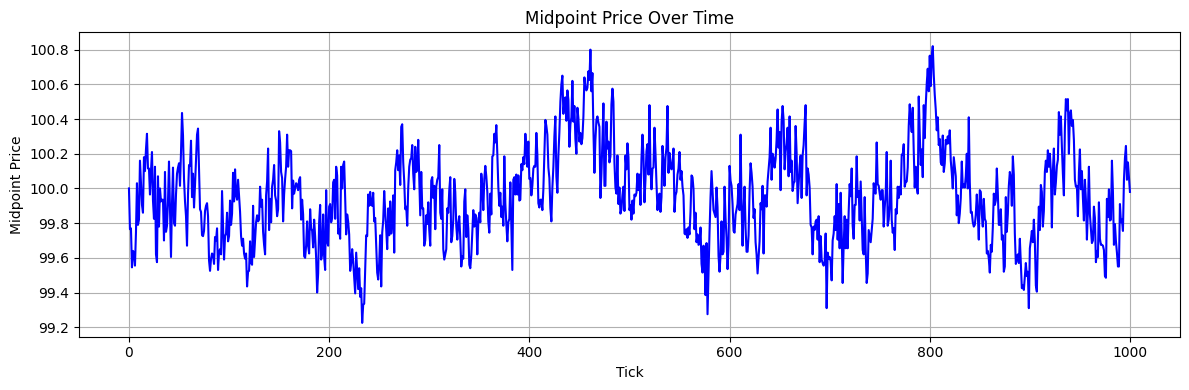

In [54]:
ticks = list(range(len(midpoint_prices)))

plt.figure(figsize=(12, 4))
plt.plot(ticks, midpoint_prices, color='blue')
plt.xlabel("Tick")
plt.ylabel("Midpoint Price")
plt.title("Midpoint Price Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

In [55]:
simulation.get_user_portfolio(agent_id)

[0.0, 0.0]

In [56]:
simulation.get_user_portfolio(anon_id)

[0.0, 0.0]